# **Project 2: Machine Learning-based Causal Effect Estimation **

Franny Dean

Due February 25, 2025

In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from log_rank import *
from kaplan_meier import *


# Set notebook display options:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)  


### 2.1 Warm-up Exercise: Hypothesis Testing & Confounding 

Compare VAD vs. no-VAD i.e. treatment (T=1) vs. no treatment (T=0)

In [2]:
UNOS_data = pd.read_csv("data/UNOS_train.csv")
UNOS_data.columns

Index(['Unnamed: 0', 'wl_id_code', 'init_age', 'gender', 'hgt_cm_tcr',
       'wgt_kg_tcr', 'diab', 'prev_tx', 'num_prev_tx', 'ventilator_tcr',
       'ecmo_tcr', 'most_rcnt_creat', 'abo_A', 'abo_B', 'abo_O', 'abo_AB',
       'iabp_tcr', 'days_stat1', 'days_stat1a', 'days_stat2', 'days_stat1b',
       'init_bmi_calc', 'vad_while_listed', 'tah', 'inotropic', 'init_date',
       'end_date', 'Censor (Censor = 1)', 'Survival Time'],
      dtype='object')

In [3]:
# Drop negative survival times
UNOS_data = UNOS_data[UNOS_data['Survival Time']>=0]

UNOS_data.head()

,Unnamed: 0,wl_id_code,init_age,gender,hgt_cm_tcr,wgt_kg_tcr,diab,prev_tx,num_prev_tx,ventilator_tcr,ecmo_tcr,most_rcnt_creat,abo_A,abo_B,abo_O,abo_AB,iabp_tcr,days_stat1,days_stat1a,days_stat2,days_stat1b,init_bmi_calc,vad_while_listed,tah,inotropic,init_date,end_date,Censor (Censor = 1),Survival Time
0,0,190772,58,1,168.00,70.00,0,0,0,0,0,1.1,0,0,1,0,0,25,0,0,0,24.801587,0,0,0,2/28/1994,3/25/1994,0,25
1,1,763510,0,1,53.00,3.70,0,1,1,0,0,0.4,0,1,0,0,0,2,0,0,0,13.171947,0,0,0,2/28/1994,3/2/1994,1,2
2,2,39269,39,1,160.00,80.00,0,0,0,0,0,0.8,1,0,0,0,0,0,0,112,0,31.250000,0,0,0,3/2/1994,6/18/1999,0,1934
3,3,656721,41,1,170.18,63.96,0,0,0,0,0,1.3,0,0,1,0,0,0,0,428,0,22.084696,0,0,0,1/23/1991,7/25/1997,0,2375
4,4,196059,22,1,165.00,61.00,0,0,0,0,0,0.8,0,0,1,0,0,0,0,536,0,22.405877,0,0,0,11/11/1992,5/20/1994,0,555


In [4]:
# Run log rank test
Z, p = log_rank_test(UNOS_data, 'vad_while_listed')
Z, p

0 83 27914 616
1.8316257075302715 1.7859437711162838
1 206 27831 616
4.559519959757106 4.425758671050776
4 187 27387 615
4.199255121042831 4.0770770151352975
0 167 27047 611
3.7725810625947425 3.664725441883278
2 198 26696 611
4.531690140845071 4.395294957542198
4 185 26338 609
4.277659655250968 4.149555249491472
0 207 26018 605
4.813398416480898 4.664246042592662
2 194 25674 605
4.571550985432734 4.430266421573313
1 146 25312 603
3.478113147914033 3.375804611563434
3 124 25066 602
2.9780579270725287 2.8922720436450167
5 140 24846 599
3.3751911776543504 3.275392458651606
2 129 24592 594
3.1158913467794402 3.0248025430101824
1 141 24352 592
3.4277266754270697 3.325170451195983
0 126 24117 591
3.0876974748103 2.996419588084963
2 140 23898 591
3.4622144112478033 3.3569530984645484
3 114 23652 589
2.8389142567224757 2.754991446944363
2 85 23455 586
2.1236410147090172 2.0631681900865355
2 100 23313 584
2.5050401063784156 2.4319160858429876
3 92 23145 582
2.3134154244977316 2.246375297909386

(7.642021036449715, 2.1383822853618054e-14)

In [5]:
# Check
from lifelines.statistics import logrank_test
import numpy as np
group_1_events = 1-UNOS_data[UNOS_data['vad_while_listed']==1]['Censor (Censor = 1)']
group_2_events = 1-UNOS_data[UNOS_data['vad_while_listed']==0]['Censor (Censor = 1)']
result = logrank_test(UNOS_data[UNOS_data['vad_while_listed']==1]['Survival Time'], 
                      UNOS_data[UNOS_data['vad_while_listed']==0]['Survival Time'],
                      event_observed_A=group_1_events, event_observed_B=group_2_events)
result.print_summary()
# Extract test statistic and variance
chi2_statistic = result.test_statistic  # Log-rank chi-square statistic
z_score = np.sqrt(chi2_statistic)  # Approximate to normal distribution

# Compute p-value using standard normal distribution
p_value_normal = 2 * (1 - norm.cdf(abs(z_score)))  # Two-tailed test
p_value_normal,z_score


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          58.40 <0.005     45.41

(2.1316282072803006e-14, 7.642021036449709)

Confounders are correlated with the treatment and outcome (survival). To test if a variable is a confounder, I run a linear regression for each the treatment VAD and outcome on the set of X in the data and look at which coefficients are significant predictors of both.

Reminder the interpretation of each variable:

- "init_age": Patient's age at time of enrolling in the wait-list
- "gender": Patient's biological sex
- "hgt_cm_tcr": Patient's height in cm
- "wgt_kg_tcr": Patient's weight in kgs
- "diab": Indication on whether or not the patient is diabetic
- "abo_A": Indication on whether patient's blood type is A
- "abo_B": Indication on whether patient's blood type is B
- "abo_O": Indication on whether patient's blood type is O
- "ventilator_tcr": Indication on whether the patient was dependent on a ventilator at time of enrollment in the wait-list
- "ecmo_tcr": Indication on whether the patient was treated with ECMO (extracorporeal membrane oxygenation) by the time they where enrolled in the wait-list. ECMO is an artificial life support that continuously pumps blood out of the patient's body and sends it through a series of devices that add oxygen and remove carbon dioxide, pumping the blood back to the patient. It is used for a patient whose heart and lungs are not functioning properly.  
- "most_rcnt_creat": Creatinine level in the patient's most recent blood test before enrolling in wait-list.
- "vad_while_listed": Whether the patient was on ventricular assist device (VAD) support when listed for a heart transplant. VAD is a mechanical pump used to restore cardiac function by pumping blood from the lower chambers of the heart to the rest of the body.
- "iabp_tcr": Whether the patient was on Intra-Aortic Balloon Pump (IABP) Therapy. This is a therapeutic device used to improve blood flow when the heart is unable to pump enough blood for your body.
- "init_bmi_calc": Patient's Body Mass Index at time of enrollment in the wait-list.
- "tah": Whether the patient underwent a total artificial heart (TAH) surgery. This is a mechanical pump that replaces the heart when it is not working as it should.
- "inotropic": Whether the patient was on an Inotropic drug at time of enrollment in wait-list. These are medicines that change the force of the heart's contractions.
- "days_stat1", "days_stat1a", "days_stat1b", "days_stat2": UNOS has an internal system for classifying the priority of patients for receiving a heart transplant. Individuals classified as Status 1A have the highest priority on the heart transplant waiting list. Status 1A are individuals who must stay in the hospital as in-patients and require high doses of intravenous drugs, require a VAD for survival, are dependent on a ventilator or have a life expectancy of a week or less without a transplant. Individuals classified as Status 1B are generally not required to stay in the hospital as in-patients. All other candidates for the transplant are listed under Status 2. These variables indicate the number of days a patient spends in each status during the time between their enrollment in the wait-list and death or reception of a transplant.
- "Censor (Censor = 1)": Indication of censoring
- "Survival Time": Time between enrollment in wait-list and death

In [6]:
# Check for confounders
Xs = ['init_age', 'gender', 'hgt_cm_tcr',
       'wgt_kg_tcr', 'diab', 'ventilator_tcr',
       'ecmo_tcr', 'most_rcnt_creat', 'abo_A', 'abo_B', 'abo_O', 'abo_AB',
       'iabp_tcr', 
       'init_bmi_calc', 'tah', 'inotropic']

# Normalize age, height, weight, creatinine, bmi
UNOS_data["init_age"] = (UNOS_data["init_age"] - UNOS_data["init_age"].mean()) / UNOS_data["init_age"].std()
UNOS_data["hgt_cm_tcr"] = (UNOS_data["hgt_cm_tcr"] - UNOS_data["hgt_cm_tcr"].mean()) / UNOS_data["hgt_cm_tcr"].std()
UNOS_data["wgt_kg_tcr"] = (UNOS_data["wgt_kg_tcr"] - UNOS_data["wgt_kg_tcr"].mean()) / UNOS_data["wgt_kg_tcr"].std()
UNOS_data["most_rcnt_creat"] = (UNOS_data["most_rcnt_creat"] - UNOS_data["most_rcnt_creat"].mean()) / UNOS_data["most_rcnt_creat"].std()
UNOS_data["init_bmi_calc"] = (UNOS_data["init_bmi_calc"] - UNOS_data["init_bmi_calc"].mean()) / UNOS_data["init_bmi_calc"].std()

Xs_with_const = sm.add_constant(UNOS_data[Xs])
propensity_model = sm.OLS(UNOS_data['vad_while_listed'], Xs_with_const).fit()
propensity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       vad_while_listed   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     25.58
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           6.37e-72
Time:                        12:55:36   Log-Likelihood:                 14121.
No. Observations:               27914   AIC:                        -2.821e+04
Df Residuals:                   27898   BIC:                        -2.808e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0225      0.002     11.984      0.000       0.019       0.026
init_age            0.0051      0.001      3.958      0.000       0.003       0.008
gender             -0.0137      0.002     -6.226      0.000      -0.018      -0.009
hgt_cm_tcr         -0.0045      0.002     -2.262      0.024      -0.008      -0.001
wgt_kg_tcr          0.0092      0.002      4.236      0.000       0.005       0.013
diab                0.0044      0.002      1.989      0.047    6.31e-05       0.009
ventilator_tcr     -0.0030      0.004     -0.825      0.409      -0.010       0.004
ecmo_tcr            0.0010      0.006      0.158      0.874      -0.011       0.013
most_rcnt_creat    -0.0008      0.001     -0.875      0.381      -0.003       0.001
abo_A               0.0056      0.002      3.243      0.001       0.002       0.009
abo_B               0.0058      0.002      2.421      0.015       0.001       0.010
abo_O               0.0121      0.002      7.629      0.000       0.009       0.015
abo_AB             -0.0011      0.004     -0.251      0.802      -0.009       0.007
iabp_tcr            0.0572      0.004     12.746      0.000       0.048       0.066
init_bmi_calc      -0.0006      0.001     -0.446      0.655      -0.003       0.002
tah                -0.0116      0.019     -0.613      0.540      -0.049       0.025
inotropic          -0.0250      0.003     -7.798      0.000      -0.031      -0.019
==============================================================================
Omnibus:                    32149.796   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1985193.298
Skew:                           6.377   Prob(JB):                         0.00
Kurtosis:                      42.296   Cond. No.                     2.85e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  1e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [7]:

Xs_with_const = sm.add_constant(UNOS_data[Xs])
sm_model = sm.OLS(UNOS_data['Survival Time'], Xs_with_const).fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Survival Time   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     91.24
Date:                Wed, 19 Feb 2025   Prob (F-statistic):          7.67e-276
Time:                        12:55:36   Log-Likelihood:            -2.2966e+05
No. Observations:               27914   AIC:                         4.594e+05
Df Residuals:                   27898   BIC:                         4.595e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             513.5668     11.633     44.149      0.000     490.766     536.367
init_age           -8.7080      8.055     -1.081      0.280     -24.495       7.079
gender            -66.4667     13.624     -4.879      0.000     -93.170     -39.764
hgt_cm_tcr        -30.0250     12.292     -2.443      0.015     -54.118      -5.932
wgt_kg_tcr        151.8852     13.441     11.300      0.000     125.540     178.231
diab              -68.1565     13.709     -4.972      0.000     -95.027     -41.286
ventilator_tcr   -227.3221     22.619    -10.050      0.000    -271.656    -182.988
ecmo_tcr         -128.6082     38.557     -3.336      0.001    -204.182     -53.035
most_rcnt_creat   -32.3859      5.630     -5.753      0.000     -43.420     -21.352
abo_A             129.2487     10.806     11.961      0.000     108.068     150.429
abo_B             133.8990     14.818      9.037      0.000     104.856     162.942
abo_O             247.9795      9.842     25.195      0.000     228.688     267.271
abo_AB              2.4395     26.250      0.093      0.926     -49.013      53.891
iabp_tcr         -262.3851     27.834     -9.427      0.000    -316.942    -207.829
init_bmi_calc       4.1737      8.039      0.519      0.604     -11.584      19.931
tah              -284.5785    117.223     -2.428      0.015    -514.341     -54.816
inotropic        -236.7605     19.873    -11.914      0.000    -275.712    -197.809
==============================================================================
Omnibus:                    17702.065   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205754.488
Skew:                           2.948   Prob(JB):                         0.00
Kurtosis:                      14.923   Cond. No.                     2.85e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  1e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [8]:
# Normal kaplan-meier curves without propensity weighting
no_treatment = UNOS_data[UNOS_data['vad_while_listed']==0]
no_treatment['event'] = 1 - no_treatment['Censor (Censor = 1)']
treatment = UNOS_data[UNOS_data['vad_while_listed']==1]
treatment['event'] = 1 - treatment['Censor (Censor = 1)']
surv_dataframe_treatment = fit_km(treatment['Survival Time'],treatment['event'])
surv_dataframe_no_treatment = fit_km(no_treatment['Survival Time'],no_treatment['event'])

/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/286501326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_treatment['event'] = 1 - no_treatment['Censor (Censor = 1)']
/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/286501326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment['event'] = 1 - treatment['Censor (Censor = 1)']


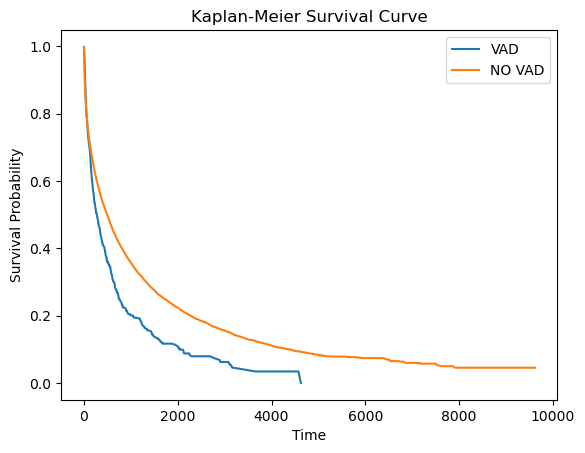

In [9]:
def compare_km(df1, df2, label1='VAD', label2='NO VAD', time_col='T'):
  """
  Plot Kaplan-Meier survival curve.

  Parameters:
    df: DataFrame with survival, after T, E, C passed to fit_km
  """
  plt.plot(df1[time_col], df1['S'], label=label1)
  plt.plot(df2[time_col], df2['S'], label=label2)
  plt.xlabel('Time')
  plt.ylabel('Survival Probability')  
  plt.title('Kaplan-Meier Survival Curve')
  plt.legend()
  plt.show()

compare_km(surv_dataframe_treatment, surv_dataframe_no_treatment)

In [10]:
# Run a propensity score model
propensity_model.predict(Xs_with_const)
UNOS_data['propensity'] = propensity_model.predict(Xs_with_const)
no_treatment = UNOS_data[UNOS_data['vad_while_listed']==0]
no_treatment['event'] = 1 - no_treatment['Censor (Censor = 1)']
treatment = UNOS_data[UNOS_data['vad_while_listed']==1]
treatment['event'] = 1 - treatment['Censor (Censor = 1)']

/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/1111119090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_treatment['event'] = 1 - no_treatment['Censor (Censor = 1)']
/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/1111119090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment['event'] = 1 - treatment['Censor (Censor = 1)']


In [11]:

# Run propensity km overall
weighted_surv_dataframe = fit_weighted_km(UNOS_data['Survival Time'],1-UNOS_data['Censor (Censor = 1)'], UNOS_data['vad_while_listed'], UNOS_data['propensity'])

# Run propensity km - treated group
weighted_surv_dataframe_treatment = fit_weighted_km(treatment['Survival Time'],treatment['event'], treatment['vad_while_listed'], treatment['propensity'])

# Run propensity km - untreated group
weighted_surv_dataframe_no_treatment = fit_weighted_km(no_treatment['Survival Time'],no_treatment['event'], no_treatment['vad_while_listed'],no_treatment['propensity'])


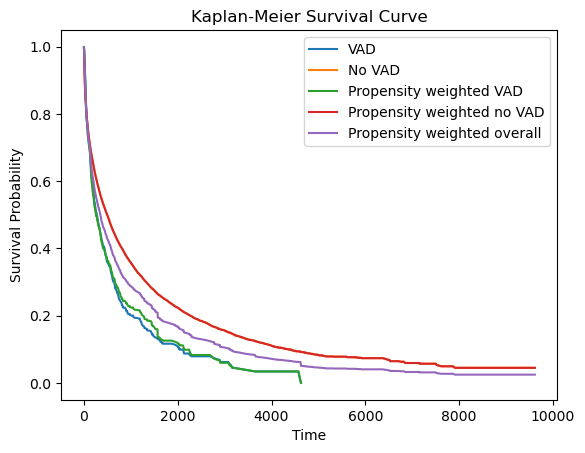

In [12]:
def compare_km_w_propensity(df1, df2, df3, df4, df5,
                            label1='VAD', label2='No VAD', label3='Propensity weighted VAD', 
                            label4='Propensity weighted no VAD', label5='Propensity weighted overall',
                            time_col='T'):
  """
  Plot Kaplan-Meier survival curve.

  Parameters:
    df: DataFrame with survival, after T, E, C passed to fit_km
  """
  plt.plot(df1[time_col], df1['S'], label=label1)
  plt.plot(df2[time_col], df2['S'], label=label2)
  plt.plot(df3[time_col], df3['S'], label=label3)
  plt.plot(df4[time_col], df4['S'], label=label4)
  plt.plot(df5[time_col], df5['S'], label=label5)
  plt.xlabel('Time')
  plt.ylabel('Survival Probability')  
  plt.title('Kaplan-Meier Survival Curve')
  plt.legend()
  plt.show()

compare_km_w_propensity(surv_dataframe_treatment, surv_dataframe_no_treatment, 
                        weighted_surv_dataframe_treatment, weighted_surv_dataframe_no_treatment,
                        weighted_surv_dataframe)

In [13]:
# Run propensity log rank test
Z, p = weighted_log_rank_test(UNOS_data, 'vad_while_listed')
Z, p

(30.01737337250063, 5.82303660378598e-198)

### 2.2 ML-based Estimation of Average Treatment Effects

In [14]:
# Estimate the effect of aspirin and heparin on 14 day mortality with various estimators
# DASP14 - Aspirin given for 14 days or till death or discharge (Y/N)
# DLH14
# Low dose heparin given for 14 days or till death/discharge (Y/N)
# DMH14
# Medium dose heparin given for 14 days or till death/discharge (Y/N)
# DHH14
# Medium dose heparin given for 14 days etc in pilot (combine with above)
# OR
# RXASP
# Trial aspirin allocated (Y/N)
# RXHEP
# Trial heparin allocated (M/L/N) [M is coded as H=high in pilot]
# DALIVE
# Discharged alive from hospital
# DALIVED
# Date of above (yyyy/mm/dd)
# DPLACE
# Discharge destination (A-Home/B-Relatives home/C-Residential care/D-Nursing home/E-Other hospital departments/U-Unknown)
# DDEAD
# Dead on discharge form
# DDEADD
# Date of above (yyyy/mm/dd); NOTE: this death is not necessarily within 14 days of randomisation

IST_data = pd.read_csv("data/IST/IST_observational.csv")#[['DASP14', 'DLH14', 'DMH14','DHH14','DALIVE']]

# Convert to 1/0
IST_data['DALIVE'] = IST_data['DALIVE'].apply(lambda x: 1 if x=='Y' else 0)
IST_data['DASP14'] = IST_data['DASP14'].apply(lambda x: 1 if x=='Y' else 0)
IST_data['DLH14'] = IST_data['DLH14'].apply(lambda x: 1 if x=='Y' else 0)
IST_data['DMH14'] = IST_data['DMH14'].apply(lambda x: 1 if x=='Y' else 0)
IST_data['DHH14'] = IST_data['DHH14'].apply(lambda x: 1 if x=='Y' else 0)

# Treatment variable
IST_data['treatment_asp'] = (IST_data['DASP14'])>0
IST_data['treatment_hep'] = (IST_data['DLH14'] + IST_data['DMH14'] + IST_data['DHH14'])>0
IST_data['treatment'] = IST_data['treatment_asp'] | IST_data['treatment_hep']
IST_data['treatment'] = IST_data['treatment'].apply(lambda x: 1 if x else 0)
IST_data['treatment_asp'] = IST_data['treatment_asp'].apply(lambda x: 1 if x else 0)
IST_data['treatment_hep'] = IST_data['treatment_hep'].apply(lambda x: 1 if x else 0)
IST_data = IST_data.drop(['DASP14', 'DLH14', 'DMH14','DHH14'], axis=1)

# Outcome variable
IST_data['event'] = 1 - IST_data['DALIVE']
IST_data = IST_data.drop(['DALIVE'], axis=1)

# Clean data
IST_data_covariates = IST_data



In [15]:
IST_data_covariates['RATRIAL'].unique()

array([nan, 'N', 'Y'], dtype=object)

In [16]:
# Standard difference-in-means estimator
mean1 = IST_data[IST_data['treatment']==1]['event'].mean()
mean0 = IST_data[IST_data['treatment']==0]['event'].mean()
diff_in_means = mean1 - mean0
print(diff_in_means)

# Estimating variance and making confidence intervals
ste1 = IST_data[IST_data['treatment']==1]['event'].std()/np.sqrt(IST_data[IST_data['treatment']==1].shape[0])
ste0 = IST_data[IST_data['treatment']==0]['event'].std()/np.sqrt(IST_data[IST_data['treatment']==0].shape[0])
ste_diff = np.sqrt(ste1**2 + ste0**2)
z_score = diff_in_means/ste_diff
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # both sides
print(p_value)


-0.06290595298708124
2.4048790653985463e-05


In [38]:
# Inverse propensity weighting (IPW) estimator using a Gradient Boosting model for the propensity scores.

# Data cleaning
covariates_to_use = ['HOSPNUM', 'AGE','RCONSC','SEX','RSLEEP','RATRIAL','RCT','RVISINF','RHEP24',
                     'RASP3','RSBP','RDEF1','RDEF2','RDEF3','RDEF4','RDEF5','RDEF6','RDEF7','RDEF8',
                     'DAYLOCAL']
X = IST_data_covariates[covariates_to_use]
X['AGE'] = (X['AGE'] - X['AGE'].mean()) / X['AGE'].std()
X['RSBP'] = (X['RSBP'] - X['RSBP'].mean()) / X['RSBP'].std()
X = pd.get_dummies(X, columns=['RCONSC'], prefix='RCONSC')
X = pd.get_dummies(X, columns=['SEX'], prefix='SEX')
X = pd.get_dummies(X, columns=['RSLEEP'], prefix='RSLEEP')
X = pd.get_dummies(X, columns=['RDEF1'], prefix='RDEF1')
X = pd.get_dummies(X, columns=['RDEF2'], prefix='RDEF2')
X = pd.get_dummies(X, columns=['RDEF3'], prefix='RDEF3')
X = pd.get_dummies(X, columns=['RDEF4'], prefix='RDEF4')
X = pd.get_dummies(X, columns=['RDEF5'], prefix='RDEF5')
X = pd.get_dummies(X, columns=['RDEF6'], prefix='RDEF6')
X = pd.get_dummies(X, columns=['RDEF7'], prefix='RDEF7')
X = pd.get_dummies(X, columns=['RDEF8'], prefix='RDEF8')
X = pd.get_dummies(X, columns=['RVISINF'], prefix='RVISINF')
X = pd.get_dummies(X, columns=['RHEP24'], prefix='RHEP24')
X = pd.get_dummies(X, columns=['RASP3'], prefix='RASP3')
X = pd.get_dummies(X, columns=['RATRIAL'], prefix='RATRIAL')
X = pd.get_dummies(X, columns=['RCT'], prefix='RCT')
X = pd.get_dummies(X, columns=['DAYLOCAL'], prefix='DAYLOCAL')


y = IST_data['treatment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient boosted model training
propensity_model = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=3, random_state=42)
propensity_model.fit(X_train, y_train)

y_pred = propensity_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:\n", roc_auc_score(y_test, y_pred))

# Predict propensity scores
propensity_scores = propensity_model.predict_proba(X)[:,1]

# Estimate IPW
ipw = (IST_data['treatment'] * IST_data['event'] / propensity_scores) - ((1 - IST_data['treatment']) * IST_data['event'] / (1 - propensity_scores))
ipw_estimate = ipw.mean()
print(ipw_estimate)

# Estimate variance assuming this comes from normal distribution too
ipw_ste = ipw.std()/np.sqrt(ipw.shape[0])
z_score = ipw_estimate/ipw_ste
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # both sides
print(p_value)

/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/2355722627.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['AGE'] = (X['AGE'] - X['AGE'].mean()) / X['AGE'].std()
/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/2355722627.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['RSBP'] = (X['RSBP'] - X['RSBP'].mean()) / X['RSBP'].std()


Accuracy: 0.6306400839454355
AUC:
 0.5413113427755717
-0.0134421960619517
0.5223462088121718


In [18]:
def preprocess(X):
    X['AGE'] = (X['AGE'] - X['AGE'].mean()) / X['AGE'].std()
    X['RSBP'] = (X['RSBP'] - X['RSBP'].mean()) / X['RSBP'].std()
    X = pd.get_dummies(X, columns=['RCONSC'], prefix='RCONSC')
    X = pd.get_dummies(X, columns=['SEX'], prefix='SEX')
    X = pd.get_dummies(X, columns=['RSLEEP'], prefix='RSLEEP')
    X = pd.get_dummies(X, columns=['RDEF1'], prefix='RDEF1')
    X = pd.get_dummies(X, columns=['RDEF2'], prefix='RDEF2')
    X = pd.get_dummies(X, columns=['RDEF3'], prefix='RDEF3')
    X = pd.get_dummies(X, columns=['RDEF4'], prefix='RDEF4')
    X = pd.get_dummies(X, columns=['RDEF5'], prefix='RDEF5')
    X = pd.get_dummies(X, columns=['RDEF6'], prefix='RDEF6')
    X = pd.get_dummies(X, columns=['RDEF7'], prefix='RDEF7')
    X = pd.get_dummies(X, columns=['RDEF8'], prefix='RDEF8')
    X = pd.get_dummies(X, columns=['RVISINF'], prefix='RVISINF')
    X = pd.get_dummies(X, columns=['RHEP24'], prefix='RHEP24')
    X = pd.get_dummies(X, columns=['RASP3'], prefix='RASP3')
    X = pd.get_dummies(X, columns=['RATRIAL'], prefix='RATRIAL')
    X = pd.get_dummies(X, columns=['RCT'], prefix='RCT')
    X = pd.get_dummies(X, columns=['DAYLOCAL'], prefix='DAYLOCAL')
    return X

In [39]:
# A covariate adjustment estimator using a Gradient Boosting model with T-learner, S-learner, and X-learner architectures.

# T-learner - train two models, one for treated and one for untreated
# treated
X = IST_data_covariates[IST_data_covariates['treatment']==1][covariates_to_use]
X = preprocess(X)
y = IST_data_covariates[IST_data_covariates['treatment']==1]['event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient boosted model training
u_treat = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
u_treat.fit(X_train, y_train)

y_pred = u_treat.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:\n", roc_auc_score(y_test, y_pred))

# untreated
X = IST_data_covariates[IST_data_covariates['treatment']==0][covariates_to_use]
X = preprocess(X)
y = IST_data_covariates[IST_data_covariates['treatment']==0]['event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient boosted model training
u_no_treat = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
u_no_treat.fit(X_train, y_train)

y_pred = u_no_treat.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:\n", roc_auc_score(y_test, y_pred))

# Predict propensity scores
full_X = IST_data_covariates[covariates_to_use]
full_X = preprocess(full_X)
u_no_treat_scores = u_no_treat.predict_proba(full_X)[:,1]
u_treat_scores = u_treat.predict_proba(full_X)[:,1]

# Estimate effect size...
print((u_treat_scores - u_no_treat_scores).mean())

# confidence interval assuming normal
ste1 = u_treat_scores.std()/np.sqrt(u_treat_scores.shape[0])
ste0 = u_no_treat_scores.std()/np.sqrt(u_no_treat_scores.shape[0])
ste_diff = np.sqrt(ste1**2 + ste0**2)
z_score = diff_in_means/ste_diff
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # both sides
print(p_value)

Accuracy: 0.6593591905564924
AUC:
 0.6597132127005805
Accuracy: 0.667590027700831
AUC:
 0.660636645962733
-0.045205368931709074
0.0


/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/3724904802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['AGE'] = (X['AGE'] - X['AGE'].mean()) / X['AGE'].std()
/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/3724904802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['RSBP'] = (X['RSBP'] - X['RSBP'].mean()) / X['RSBP'].std()


In [40]:
# S-learner - train one model for the whole dataset include treatment as covariate
X = IST_data_covariates[covariates_to_use + ['treatment']]
X = preprocess(X)
y = IST_data_covariates['event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient boosted model training
u_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
u_model.fit(X_train, y_train)

y_pred = u_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:\n", roc_auc_score(y_test, y_pred))

# Predict 
X_0 = X.copy()
X_0['treatment'] = 0
X_1 = X.copy()
X_1['treatment'] = 1
u_no_treat_scores = u_model.predict_proba(X_0)[:,1]
u_treat_scores = u_model.predict_proba(X_1)[:,1]

# Estimate effect size...
print((u_treat_scores - u_no_treat_scores).mean())

# confidence interval assuming normal
ste1 = u_treat_scores.std()/np.sqrt(u_treat_scores.shape[0])
ste0 = u_no_treat_scores.std()/np.sqrt(u_no_treat_scores.shape[0])
ste_diff = np.sqrt(ste1**2 + ste0**2)
z_score = diff_in_means/ste_diff
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # both sides
print(p_value)


/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/3724904802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['AGE'] = (X['AGE'] - X['AGE'].mean()) / X['AGE'].std()
/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/3724904802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['RSBP'] = (X['RSBP'] - X['RSBP'].mean()) / X['RSBP'].std()


Accuracy: 0.6568730325288562
AUC:
 0.6562792133345092
-0.013358412453852135
0.0


In [41]:
# X-learner - train two models, one for treated and one for untreated, and then use the other model to predict the outcome
# Using the separate models trained for t learner above

# models: u_treat, u_no_treat
# estimator: T_i(Y_i - u_no_treat(X_i)) + (1- T_i)(u_treat(X_i)- Y_i)

# Predict
X_treat = IST_data_covariates[IST_data_covariates['treatment']==1][covariates_to_use]
X_treat = preprocess(X_treat)
y_treat = IST_data_covariates[IST_data_covariates['treatment']==1]['event']
X_no_treat = IST_data_covariates[IST_data_covariates['treatment']==0][covariates_to_use]
X_no_treat = preprocess(X_no_treat)
y_no_treat = IST_data_covariates[IST_data_covariates['treatment']==0]['event']

estimator_treat = (y_treat - u_no_treat.predict_proba(X_treat)[:,1]) 
estimator_no_treat = (u_treat.predict_proba(X_no_treat)[:,1] - y_no_treat)

estimator = estimator_treat.mean() + estimator_no_treat.mean()
print(estimator)

# confidence interval assuming normal
ste1 = estimator_treat.std()/np.sqrt(estimator_treat.shape[0])
ste0 = estimator_no_treat.std()/np.sqrt(estimator_no_treat.shape[0])
ste_diff = np.sqrt(ste1**2 + ste0**2)
z_score = diff_in_means/ste_diff
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # both sides
print(p_value)


-0.07727041007107335
8.622815861780708e-06


In [55]:
#IST_data_covariates.head(100)

In [ ]:
# An augmented IPW (doubly-robust) estimator that combines the propensity model from above and an outcomes model based on the S-learner above

# Create pseudo-outcomes
IST_data_covariates['pseudo_outcome'] = (IST_data_covariates['treatment'] / propensity_scores - (1 - IST_data_covariates['treatment']) / (1 - propensity_scores))*IST_data_covariates['event']

# Train S-learner
X = IST_data_covariates[covariates_to_use + ['treatment']]
X = preprocess(X)
y = IST_data_covariates['pseudo_outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient boosted model training
u_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
u_model.fit(X_train, y_train)

y_pred = u_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Predict
X_0 = X.copy()
X_0['treatment'] = 0
X_1 = X.copy()
X_1['treatment'] = 1
u_no_treat_scores = u_model.predict(X_0)
u_treat_scores = u_model.predict(X_1)

# Estimate effect size...
print((u_treat_scores - u_no_treat_scores).mean())

# confidence interval assuming normal
ste1 = u_treat_scores.std()/np.sqrt(u_treat_scores.shape[0])
ste0 = u_no_treat_scores.std()/np.sqrt(u_no_treat_scores.shape[0])
ste_diff = np.sqrt(ste1**2 + ste0**2)
z_score = diff_in_means/ste_diff
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # both sides
print(p_value)

# NOT SURE THIS IS ACCURATE

/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/3724904802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['AGE'] = (X['AGE'] - X['AGE'].mean()) / X['AGE'].std()
/var/folders/xb/4m309pr53_72wtxx109d4r_80000gn/T/ipykernel_72675/3724904802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['RSBP'] = (X['RSBP'] - X['RSBP'].mean()) / X['RSBP'].std()


Mean Squared Error (MSE): 1.0460
Mean Absolute Error (MAE): 0.9100
R² Score: 0.5465
2.14067493799242
0.0


Compare to original trial results:

 Among heparin-allocated patients, there were non-significantly fewer deaths within 14 days (876 [9.0%] heparin vs 905 [9.3%] no heparin), corresponding to 3 (SD 4) fewer deaths per 1000 patients. 

 
 Aspirin-allocated patients had significantly fewer recurrent ischaemic strokes within 14 days (2.8% vs 3.9%) with no significant excess of haemorrhagic strokes (0.9% vs 0.8%), so the reduction in death or non-fatal recurrent stroke with aspirin (11.3% vs 12.4%) was significant.

 Source: <https://pubmed.ncbi.nlm.nih.gov/9174558/>

In [23]:
file = pd.read_csv("data/ihdp_project2.csv.gz")
file.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,T,Y,Y_cf,Y1,Y0,ITE,ps,CATE
0,0,0.316588,0.596582,-0.360898,-0.879606,0.371086,-1.189018,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,6.221720,6.221720,6.221720,1.938568,4.283151,0.096134,4.651689
1,1,0.186891,0.196818,-0.360898,0.161703,-1.379396,0.467138,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.899687,5.741144,5.741144,3.899687,1.841458,0.346382,4.029681
2,2,0.532750,0.196818,-0.360898,-0.879606,1.934016,-1.354634,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,2.405894,6.709281,6.709281,2.405894,4.303386,0.071968,4.644078
3,3,0.294972,-0.202946,-0.360898,-0.879606,0.121017,-1.023402,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.469327,6.868562,6.868562,1.469327,5.399234,0.294487,4.635409
4,4,-0.548057,-0.202946,-0.360898,-0.879606,0.183534,-0.360940,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.558776,6.471721,6.471721,0.558776,5.912945,0.138918,4.509761


### 2.3 Counterfactual Inference and Domain Adaptation

In [24]:
# Implement TARNet and CFRMMD in paper in pytorch

# Evaluate on synthetic data